Processing time steps: 100%|██████████| 4/4 [00:00<00:00, 617.74it/s]


Hamiltonian is [[-2.90338583e+00+0.j -2.47176334e-44+0.j]
 [-2.47176334e-44+0.j -7.27990000e-01+0.j]]
Eigenvalues are [-2.90338583 -0.72799   ]
P is [[-1.00000000e+00+0.j  1.13623613e-44+0.j]
 [-1.13623613e-44+0.j -1.00000000e+00+0.j]]
D is [[-1.00000000e+00+0.j  1.13623613e-44+0.j]
 [-1.13623613e-44+0.j -1.00000000e+00+0.j]]
P_inv is [[-1.00000000e+00-0.j -1.13623613e-44-0.j]
 [ 1.13623613e-44+0.j -1.00000000e+00-0.j]]
c is in the first process [0.93251572+0.36112938j 0.        +0.j        ]
c is in the second process [-9.32515721e-01-3.61129381e-01j  1.05955805e-44+4.10328250e-45j]
c is in the third process [-4.46061696e-01-8.95002214e-01j -1.09486434e-44-3.03816769e-45j]
c is in the fourth process [4.46061696e-01+8.95002214e-01j 1.60169575e-44+1.32075062e-44j]
c is in the last process [ 9.27479489e-02+9.95689619e-01j -1.24005061e-44+1.66495825e-44j]
Hamiltonian is [[-2.90338583e+00+0.j  3.32088431e-06+0.j]
 [ 3.32088431e-06+0.j -7.27990000e-01+0.j]]
Eigenvalues are [-2.90338583 -0.7

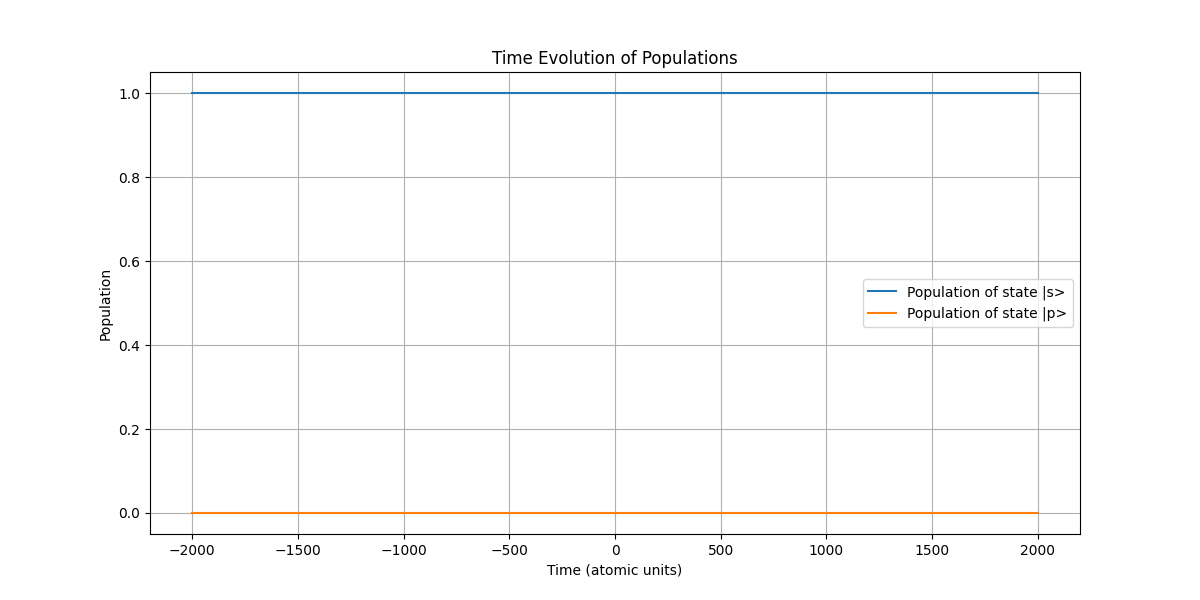

In [1]:
import numpy as np
from scipy.linalg import expm, eigh
from tqdm import tqdm

# Constants
## Conversion factor from eV to Hartree
conversion_factor = 0.0367493
E0 = 10
omega = -0.72799
phi1 = 0.0
tau_G = 200

# Time array
start_time = -2000
stop_time = 2000
steps = 4
t_values = np.linspace(start_time, stop_time, steps)
dt = t_values[1] - t_values[0]

# Conversion factor from eV to Hartree
conversion_factor = 0.0367493
# Energies and dipole elements
d_sp = 0.45
# Given energy values in eV
omega_s, omega_p = -2.90338583, -0.72799

# Initial Hamiltonian without the field
H0 = np.array([
    [omega_s, 0],
    [0, omega_p],
], dtype=complex)
# Electric field functions
def E_omega(t):
    return E0 * np.exp(-(t / tau_G)**2) * np.cos(omega * t + phi1)

# Precompute field values
E_omega_values = np.array([E_omega(t) for t in t_values]) # Ensure this is a NumPy array


def hamiltonian(E_om):
    H = np.zeros((len(E_om), 2, 2), dtype=complex)
    for i in range(len(E_om)):  # Corrected loop
        H[i, 0, 1] = d_sp * E_om[i]
        H[i, 1, 0] = d_sp * E_om[i]
    return H

Hamil_t = hamiltonian(E_omega_values)

U0_half_dt = expm(-1j * H0 * dt / 2)
c = np.array([1, 0], dtype=complex)
c_t = []
# Process time steps
for idx in tqdm(range(len(t_values)), desc="Processing time steps"):
    E_om = E_omega_values[idx]
    H_t = np.array([[omega_s, d_sp * E_om], [d_sp * E_om, omega_p]], dtype=complex)
    print(f'Hamiltonian is {H_t}')
    # Diagonalize H_t to get unitary P and diagonal D
    eigenvalues, P = eigh(H_t)
    print(f'Eigenvalues are {eigenvalues}')
    print(f'P is {P}')
    # Create the diagonal matrix for the evolution
    D = np.diag(np.exp(-1j * eigenvalues * dt))
    print(f'D is {P}')
    # Compute the inverse of P
    P_inv = np.linalg.inv(P)
    print(f'P_inv is {P_inv}')
    # Apply the sequence of operations
    c = U0_half_dt @ c        # First half of static evolution
    print(f'c is in the first process {c}')
    c = P_inv @ c             # Transform to the eigenbasis
    print(f'c is in the second process {c}')
    c = D @ c                 # Dynamic evolution in diagonal basis
    print(f'c is in the third process {c}')
    c = P @ c                 # Transform back to original basis
    print(f'c is in the fourth process {c}')
    c = U0_half_dt @ c        # Second half of static evolution
    print(f'c is in the last process {c}')
    c_t.append(c.copy())


# Convert c_t to a NumPy array
c_t = np.array(c_t)

# Calculate populations
population_s = np.abs(c_t[:, 0])**2
population_p = np.abs(c_t[:, 1])**2

# Plotting
import matplotlib.pyplot as plt
%matplotlib widget
plt.figure(figsize=(12, 6))
plt.plot(t_values, population_s, label='Population of state |s>')
plt.plot(t_values, population_p, label='Population of state |p>')
plt.xlabel('Time (atomic units)')
plt.ylabel('Population')
plt.title('Time Evolution of Populations')
plt.legend()
plt.grid(True)
plt.show()